# Import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from scipy.interpolate import interp1d
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

In [2]:
numerical = ['num_likes', 
             'num_sent', 
             'sent_avg_length', 
             'num_words', 
             'num_unique_words', 
             'unique_words_percent',
             'words_exist_per_cent',
             'emotion_anger', 'emotion_fear', 'emotion_joy', 'emotion_love', 
             'emotion_sadness', 'emotion_surprise', 
             'sentiment_POSITIVE_no_prepro', 'sentiment_NEGATIVE_no_prepro', 
             'sentiment_hf_text']

txt_features = ['text_str', 'text_str_lem']

In [3]:
feats_to_keep = numerical + txt_features

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
df = pd.read_csv("drive/MyDrive/Final Project/story_data_new_feats.csv", 
                 usecols=feats_to_keep)

In [6]:
target = 'num_likes'

# Preprocessing to get general features

In [7]:
numerical.remove('num_likes')

In [8]:
X = df[numerical+txt_features]
y = df[target].copy()

In [9]:
# turn y into labels 0 and 1, given a threshold
threshold = np.quantile(y, 0.7)

In [10]:
from sklearn.preprocessing import Binarizer

bn = Binarizer(threshold=threshold).fit(df[[target]])
y = bn.transform(df[[target]])

In [11]:
# log transform for relevant distributions
for var_to_log in ['sent_avg_length', 'num_unique_words', 'emotion_love']:
    X.loc[:, var_to_log] = X.loc[:, var_to_log].apply(np.log1p)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


# Split

In [12]:
from sklearn.model_selection import train_test_split

test_size = 20/100

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=test_size, 
                                                    random_state=42, 
                                                   stratify=y)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((14598, 17), (3650, 17), (14598, 1), (3650, 1))

In [13]:
# we first infer the following data on the transformer model
X_train_tr = X_train[['text_str']]
X_test_tr = X_test[['text_str']]

In [14]:
# we then combine the results (the probits) with the general features
X_train_gen = X_train[numerical]
X_test_gen = X_test[numerical]

In [15]:
# and with the TF/IDF features
X_train_tfidf = X_train[['text_str_lem']]
X_test_tfidf = X_test[['text_str_lem']]

In [16]:
y_train = y_train.ravel()
y_test = y_test.ravel()

# Split texts for transformer

In [17]:
nb_splits = 3
cols = ['split_'+ str(i) for i in range(1, nb_splits+1)]

def split_text(row):
  nb_splits

  l = len(row['text_str'])
  chars = int(l/nb_splits)

  for i, col in zip(range(0, l, chars), cols):  
      row[col] = row['text_str'][ i : i+chars];  
  return row

In [18]:
from tqdm import tqdm
tqdm.pandas()
X_train_tr = X_train_tr.progress_apply(split_text, axis=1)
X_test_tr = X_test_tr.progress_apply(split_text, axis=1)

100%|██████████| 3650/3650 [00:05<00:00, 658.20it/s]


In [19]:
X_train_tr['story_id'] = X_train_tr.index.tolist()
X_test_tr['story_id'] = X_test_tr.index.tolist()

In [20]:
X_train_tr = X_train_tr.melt(id_vars=['story_id'], value_vars=cols)
X_test_tr = X_test_tr.melt(id_vars=['story_id'], value_vars=cols)

In [21]:
len(X_train_tr)

43794

In [22]:
X_train_tr = X_train_tr.sort_values(by=['story_id', 'variable']).reset_index(drop=True)[['value', 'story_id']]
X_test_tr = X_test_tr.sort_values(by=['story_id', 'variable']).reset_index(drop=True)[['value', 'story_id']]

In [23]:
X_train_tr_index = X_train_tr.story_id
X_test_tr_index = X_test_tr.story_id

# import transformer model

In [24]:
! pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.4 MB 5.1 MB/s 
     |████████████████████████████████| 596 kB 53.1 MB/s 
     |████████████████████████████████| 101 kB 12.8 MB/s 
     |████████████████████████████████| 6.6 MB 46.7 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [25]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained('roberta-base')

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

In [26]:
from transformers import TFAutoModelForSequenceClassification
model = TFAutoModelForSequenceClassification.from_pretrained("ilan541/OncUponTim")

Downloading:   0%|          | 0.00/664 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/476M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at ilan541/OncUponTim.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.


# Tokenize data

In [27]:
%%time
max_length = 512
X_train_tr = tokenizer(X_train_tr.value.tolist(), 
                    truncation=True, 
                    padding='max_length', 
                    max_length=max_length)

CPU times: user 1min 51s, sys: 2.41 s, total: 1min 54s
Wall time: 59.9 s


In [28]:
len(X_train_tr['input_ids'])

43794

In [29]:
%%time
X_test_tr = tokenizer(X_test_tr.value.tolist(), 
                   truncation=True, 
                   padding='max_length', 
                   max_length=max_length)

CPU times: user 28 s, sys: 569 ms, total: 28.5 s
Wall time: 14.8 s


In [30]:
X_train_tr = [np.array(X_train_tr.input_ids)]
X_test_tr = [np.array(X_test_tr.input_ids)]

# Inference

In [31]:
X_train_tr[0].shape

(43794, 512)

In [ ]:
%%time
y_pred_train_tr = model.predict(X_train_tr)

In [66]:
%%time
y_pred_test_tr = model.predict(X_test_tr)

CPU times: user 52.1 s, sys: 10.1 s, total: 1min 2s
Wall time: 7min 27s


In [73]:
from scipy.special import softmax

def get_mean_pred(X_index, model, y_pred):
  y_pred_df = pd.DataFrame()


  y_pred_df['story_id'] = X_index.values
  y_pred_df['y_pred_0'] = y_pred.logits[:,0]
  y_pred_df['y_pred_1'] = y_pred.logits[:,1]

  y_pred_all = np.array(y_pred_df[['y_pred_0', 'y_pred_1']])
  y_pred_df['y_pred_tr'] = np.argmax(y_pred_all, axis=1)

  y_pred_all = softmax(y_pred_all)

  

  return y_pred_df.groupby('story_id').mean()

In [ ]:
y_pred_train = get_mean_pred(X_train_tr_index, model, y_pred_train_tr)
y_pred_test = get_mean_pred(X_test_tr_index, model, y_pred_test_tr)

In [ ]:
np.nunique(y_pred_test.y_pred_tr)

In [77]:
X_train_gen.shape, y_pred_train_tr.shape

((14598, 15), (14598, 3))

In [44]:
# # need to normalize the transformer predictions ?
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# y_pred_train_tr = pd.DataFrame(scaler.fit_transform(y_pred_train_tr), columns=y_pred_train_tr.columns)
# y_pred_test_tr = pd.DataFrame(scaler.transform(y_pred_test_tr), columns=y_pred_test_tr.columns)


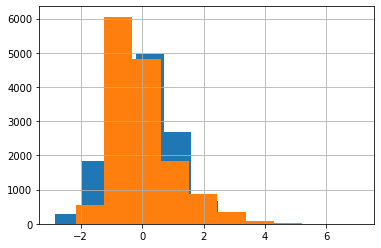

In [45]:
# visualization of the transformer predictions (hist)
y_pred_train_tr.y_pred_0.hist()
y_pred_train_tr.y_pred_1.hist()

In [ ]:
X_train_trans = y_pred_train_tr.reset_index(drop=True)
X_test_trans = y_pred_test_tr.reset_index(drop=True)

# Help functions

In [47]:
def display_model_results(model, X_train, X_test, y_train, y_test, name_model):
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)

  # display R2
  print(f'R2 on train set: {model.score(X_train, y_train)}')
  print(f'R2 on test set: {model.score(X_test, y_test)}')
  print('\n')

  # classification report
  print(classification_report(y_test, y_pred))
  print('\n')

  # confusion matric
  print('Confusion matrix:')
  print(confusion_matrix(y_test, y_pred))
  print('\n')

  # roc
  y_probs = model.predict_proba(X_test)[:,1]
  fpr, tpr, thresholds = metrics.roc_curve(y_test, y_probs)
  auc = roc_auc_score(y_test, y_probs)

  plt.figure(figsize=(10,10))
  plt.plot(fpr, tpr, label=f'{name_model}, AUC={auc:.4f}')
  plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--", label="no model. AUC=.5")
  plt.title("Receiver operating characteristic ")
  plt.xlabel('rate of false positives')
  plt.ylabel('rate of true positives')
  plt.legend(loc='best')
  plt.show()
  print('\n')

  tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

  print(f'{tp*100/(tp+fn):.2f}% of the good stories are rightly identified.')
  print(f'{fp*100/(fp+tn):.2f}% of the bad stories are identified as good ones.')

  print('\n')


  # feature importance
  try:
    cols = [x for _, x in sorted(zip(model.coef_.tolist()[0], X_train.columns))]
    plt.figure(figsize=(15,15))
    for col, coef in zip(cols, sorted(model.coef_.tolist()[0])):
      plt.barh(col, coef)
  except AttributeError:
    print('No feature importance')
  return model


In [48]:
def play_with_threshold(recall_value, X_test, y_test, model, name):
  """
  Model must be trained
  """
  y_probs = model.predict_proba(X_test)[:,1]
  precision, recall, thresholds = precision_recall_curve(y_test, y_probs)

  x = np.linspace(0,1, num=len(precision))
  y = interp1d(recall, precision)
  precision_value = y(recall_value)
  plt.figure(figsize=(10,10))
  plt.plot(recall, precision, label=name)
  plt.title("precision-recall curve")
  plt.plot(x, [precision_value]*len(recall), label=f'{precision_value:.2f}')
  plt.axvline(recall_value, label=f'{recall_value:.2f}')
  plt.xlabel('recall')
  plt.ylabel('precision')
  plt.legend()
  plt.show()

  if len(thresholds)<len(recall):
    thresholds = np.append(thresholds,0)
  y_thresholds = interp1d(recall, thresholds)
  threshold_value = y_thresholds(recall_value)
  print('\n')
  print(f'When recall is equal to {recall_value:.2f}, precision is equal to {precision_value:.4f},\
and the threshold is equal to {threshold_value:.2f}.')
  f1 = 2*(recall_value*precision_value)/(recall_value+precision_value)
  print(f'f1 is equal to {f1:.4f}')
  
  return threshold_value


In [49]:
def conf_matrix(model, threshold_proba, X_test, y_test):
  p = threshold_proba
  y_probs = model.predict_proba(X_test)[:,1]

  y_pred = (y_probs >= p).astype(int)
  tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

  print(f'{tp*100/(tp+fn):.2f}% of the good stories are rightly identified.')
  print(f'{fp*100/(fp+tn):.2f}% of the bad stories are identified as good ones.')
  print('\n')
  print(f"Confusion matrix when p={p:.2f}:")
  print(confusion_matrix(y_test, y_pred))


In [50]:
def plot_rocs(names, models, X_test, y_test):
  
  plt.figure(figsize=(10, 7))
  
  for name, model in zip(names, models):
    y_probs = model.predict_proba(X_test)[:,1]
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_probs)
    auc = roc_auc_score(y_test, y_probs)

    plt.plot(fpr, tpr, label=f'{name}, AUC={auc:.4f}')
      
  plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--", label="no model. AUC=.5")
  plt.title('ROC curves\n(Receiver Operating Characteristic)')
  plt.xlabel('rate of false positives\nFPR')
  plt.ylabel('rate of true positives\nTPR')
  plt.legend(loc='best')
  plt.show()

# General features - train model

## Preprocessing

In [51]:
# feature scaling
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_gen = pd.DataFrame(scaler.fit_transform(X_train_gen), columns=X_train_gen.columns)
X_test_gen = pd.DataFrame(scaler.transform(X_test_gen), columns=X_train_gen.columns)

X_train_gen.shape, X_test_gen.shape

((14598, 15), (3650, 15))

###add the predictions of the transformer as features to the general feature model 

In [52]:
X_train_gen.shape, X_train_trans.shape

((14598, 15), (14598, 3))

In [ ]:
X_train_gen_tr = pd.concat([X_train_gen, X_train_trans], axis=1)
X_test_gen_tr = pd.concat([X_test_gen, X_test_trans], axis=1)


In [ ]:
scaler = StandardScaler()
X_train_gen_tr = pd.DataFrame(scaler.fit_transform(X_train_gen_tr), columns=X_train_gen_tr.columns)
X_test_gen_tr = pd.DataFrame(scaler.transform(X_test_gen_tr), columns=X_train_gen_tr.columns)


In [ ]:
np.unique(X_train_gen_tr.y_pred_tr)

In [ ]:
X_train_gen_tr[X_train_gen_tr.y_pred_tr==1]

## Predictions

### Random Forest

In [ ]:
clf_rf_gen_tr = display_model_results(RandomForestClassifier(max_depth=10, random_state=0), 
                      X_train_gen_tr, X_test_gen_tr, y_train, y_test, 
                      'random forest')


In [ ]:
recall_value = 0.7 # chose wanted recall value
p_threshold = play_with_threshold(recall_value, X_test_gen_tr, y_test, clf_rf_gen_tr, 'random forest')

In [ ]:
conf_matrix(clf_rf_gen_tr, p_threshold, X_test_gen_tr, y_test)

### HistGradientBoostingClassifier

In [ ]:
from sklearn.ensemble import HistGradientBoostingClassifier
clf_hist_gen_tr = display_model_results(HistGradientBoostingClassifier(max_iter=1000), 
                      X_train_gen_tr, X_test_gen_tr, y_train, y_test, 
                      'HistGradientBoostingClassifier')

In [ ]:
recall_value = 0.7 # chose wanted recall value
p_threshold = play_with_threshold(recall_value, X_test_gen_tr, y_test, clf_hist_gen, 'clf_hist_gen')

In [ ]:
conf_matrix(clf_hist_gen, p_threshold, X_test_gen_tr, y_test)

# ROCs

In [ ]:
names = ['random forest', 'boost hist']
models = [clf_rf_gen_tr, clf_hist_gen]
plot_rocs(names, models, X_test_gen_tr, y_test)